# DENUE information

@roman

6 July, 2024

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import h3
from tqdm import tqdm
from dotenv import load_dotenv
from scipy.spatial import KDTree
# dbscan
from sklearn.cluster import DBSCAN
from INEGIpy import DENUE, MarcoGeoestadistico

In [3]:
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)

# Load environment variables
load_dotenv()

# inegi class
denue_api = DENUE(token=os.getenv('API_INEGI'))
inegi_api = MarcoGeoestadistico()


In [4]:
# params
ESTRATO_CATEGORIES = [
    '0 a 5 personas',
    '6 a 10 personas',
    '11 a 30 personas',
    '31 a 50 personas',
    '51 a 100 personas',
    '101 a 250 personas',
    '251 y más personas'
]

IMPORTANT_VARS_DENUE = [
    'CLEE', 'Nombre', 'Razon_social', 'Clase_actividad', 'estrato_category',
    'CLASE_ACTIVIDAD_ID', 'SUBRAMA_ACTIVIDAD_ID', 'AreaGeo', 'id_entidad_f',
    'Fecha_Alta', 'geometry'
]

---
# Data

## Properties

In [5]:
# read properties
gdf_properties = gpd.read_parquet("../../data/interim/cleaned_data_s6.parquet")
# info
gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 852913 entries, 0 to 852912
Data columns (total 55 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   property_id                    852913 non-null  object        
 1   valor_fisico_construccion      852913 non-null  float64       
 2   id_avaluo                      852913 non-null  object        
 3   fecha_avaluo                   852913 non-null  datetime64[ns]
 4   colonia                        852913 non-null  object        
 5   id_clase_inmueble              852913 non-null  int64         
 6   id_tipo_inmueble               852913 non-null  int64         
 7   conservacion                   852913 non-null  float64       
 8   elevador                       824546 non-null  float64       
 9   niveles                        852913 non-null  int64         
 10  cve_ref_proximidad_urbana      852913 non-null  int64       

## Mexico

In [9]:
# get mexico shapes
gdf_mexico = inegi_api.Entidades()
gdf_mexico.shape

(32, 9)

---
# DENUE's Data

In [37]:
# search denue's data
def get_denue_units(list_of_names, activity_id, max_units=100_000):
    # fetch each name
    list_units_df = []

    for name in tqdm(list_of_names):
        gdf = denue_api.BuscarAreaAct(
            nombre=name,
            clave_area='00',
            registro_inicial=0,
            registro_final=max_units,
            estrato='0'
        )
        list_units_df.append(gdf)
    
    # concat
    df_append = pd.concat(list_units_df, axis=0)

    # filter by CLASE_ACTIVIDAD_ID in activity_id
    mask = df_append['CLASE_ACTIVIDAD_ID'].isin(activity_id)
    df_append = (
        df_append
        .loc[mask]
        # drop
        .drop_duplicates('CLEE', keep='first')
        .query("Tipo == 'Fijo'")  # we want always fixed units
        # format
        .assign(
            estrato_category=lambda x: pd.Categorical(
                x['Estrato'],
                categories=ESTRATO_CATEGORIES,
                ordered=True
            ),
            Razon_social=lambda x: 
                x['Razon_social'].str.strip().str.upper(),
            id_entidad_f=lambda x: x['AreaGeo'].str[:2],
            Fecha_Alta=lambda x: pd.to_datetime(
                x['Fecha_Alta'], format='%Y-%m', errors='coerce'
            )
        )
        # drop columns
        .loc[:, IMPORTANT_VARS_DENUE]
        .reset_index(drop=True)
    )
    
    return df_append


def plot_denues(gdf, title='DENUE'):
    # plot
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, color='C0', markersize=1)
    # add titles
    plt.title(f'{title} units')
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # show
    plt.show()


def denue_eda(gdf, title='DENUE'):
    # s2: count razon social
    print(f"\n {'='*10}Razon social {'='*10}")
    print(gdf['Razon_social'].value_counts(normalize=True).head(10))

    # s3 count estrato
    print(f"\n {'='*10}Estrato {'='*10}")
    print(gdf['estrato_category'].value_counts(normalize=True).sort_index())

    # s1: plot map
    plot_denues(gdf, title)

    # s4: plot ts
    fig, ax = plt.subplots(figsize=(8, 4))
    gdf.groupby('Fecha_Alta').size().cumsum().plot(ax=ax, drawstyle='steps-post')
    # add titles
    plt.title(f'{title} units time series')
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Units')
    # ylim in 0
    plt.ylim(0, None)
    # show
    plt.show()

    # s5: plot id_entidad_f
    fig, ax = plt.subplots(figsize=(8, 4))
    gdf['id_entidad_f'].value_counts(normalize=True).sort_index().plot(kind='bar')
    # add titles
    plt.title(f'{title} units by state')
    plt.xticks(rotation=90)
    plt.xlabel('State')
    plt.ylabel('Percentage')
    # y ticks in %
    ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
    # show
    plt.show()
    return None

    


## Supermarkets

### Fetch

In [17]:
# get supermarkets
list_names = [
    'supermercado'
]

acivity_ids = [
    '462111',  # super comercio al por menor
]

# fetch
gdf_supermarkets = get_denue_units(list_names, acivity_ids)

# see the data
print(gdf_supermarkets.shape)
gdf_supermarkets.sample(5)

100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

(7179, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,id_entidad_f,Fecha_Alta,geometry
7028,09014462111000516000003579S3,TIENDA SUPERISSSTE 250,SUPERISSSTE,Comercio al por menor en supermercados,101 a 250 personas,462111,46211,090140001,09,2019-04-01,POINT (-99.15082 19.40079)
2573,09005462111000226000002514S7,BODEGA AURRERA SAN JUAN DE ARAGON 3757,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,46211,090050001,09,2010-07-01,POINT (-99.08077 19.46507)
3022,14046466112000061011001880S9,BODEGON JALOSTOTITLAN,BODESA SAPI DE CV,Comercio al por menor en supermercados,6 a 10 personas,462111,46211,140460001,14,2014-12-01,POINT (-102.46766 21.16863)
6521,19039462111000793000002514S3,SUPERAMA MONTERREY SAN JERONIMO 1247,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,51 a 100 personas,462111,46211,190390001,19,2013-07-01,POINT (-100.36812 25.67592)
5203,14108462111000024001008292S1,SORIANA EXPRESS TUXPAN JALISCO SUCURSAL 0530,TIENDAS SORIANA SA DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,46211,141080001,14,2014-12-01,POINT (-103.37404 19.56053)


In [18]:
# important supermarkets
important_supermarkets = [
    'NUEVA WAL MART DE MEXICO S DE RL DE CV',
    'TIENDAS SORIANA SA DE CV',
    'TIENDAS CHEDRAUI SA DE CV',
    'CASA LEY SAPI DE CV',
    'QAR SUPERMERCADOS SAPI DE CV',
    'CORPORACION SANCHEZ SA DE CV',
    'COMERCIAL CITY FRESKO S DE RL DE CV',
    'OPERADORA FUTURAMA SA DE CV',
    'SUPERMERCADOS INTERNACIONALES HEB SA DE CV',
    'SUPERISSSTE',
    'INSTITUTO MEXICANO DEL SEGURO SOCIAL',
    'SUPER SAN FRANCISCO DE ASIS SA DE CV',
    'COSTCO DE MEXICO SA DE CV'
]

# filter
gdf_supermarkets = (
    gdf_supermarkets
    .query("Razon_social in @important_supermarkets")
    .query("estrato_category >= '11 a 30 personas'")
    .reset_index(drop=True)
)

# see
print(gdf_supermarkets.shape)

(4647, 11)


### EDA


 ==========Razon social ==========
Razon_social
NUEVA WAL MART DE MEXICO S DE RL DE CV        0.574779
TIENDAS SORIANA SA DE CV                      0.174091
TIENDAS CHEDRAUI SA DE CV                     0.069077
CASA LEY SAPI DE CV                           0.052077
QAR SUPERMERCADOS SAPI DE CV                  0.021519
COMERCIAL CITY FRESKO S DE RL DE CV           0.018937
OPERADORA FUTURAMA SA DE CV                   0.018291
SUPERMERCADOS INTERNACIONALES HEB SA DE CV    0.014848
CORPORACION SANCHEZ SA DE CV                  0.014848
SUPERISSSTE                                   0.012266
Name: proportion, dtype: float64

 ==========Estrato ==========
estrato_category
0 a 5 personas        0.000000
6 a 10 personas       0.000000
11 a 30 personas      0.242737
31 a 50 personas      0.086723
51 a 100 personas     0.285991
101 a 250 personas    0.365827
251 y más personas    0.018722
Name: proportion, dtype: float64


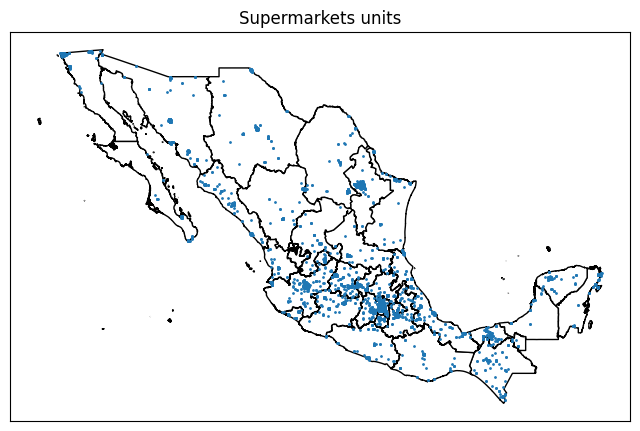

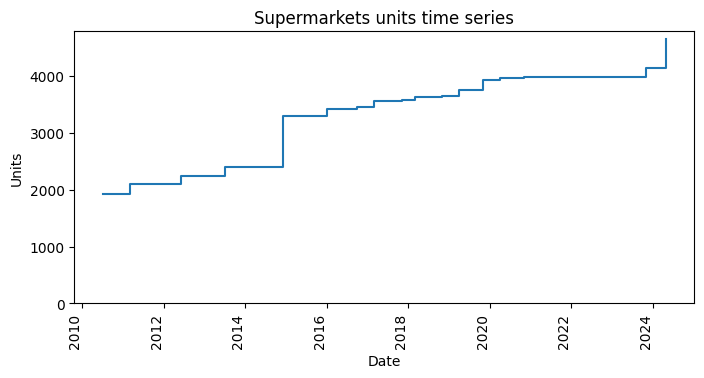

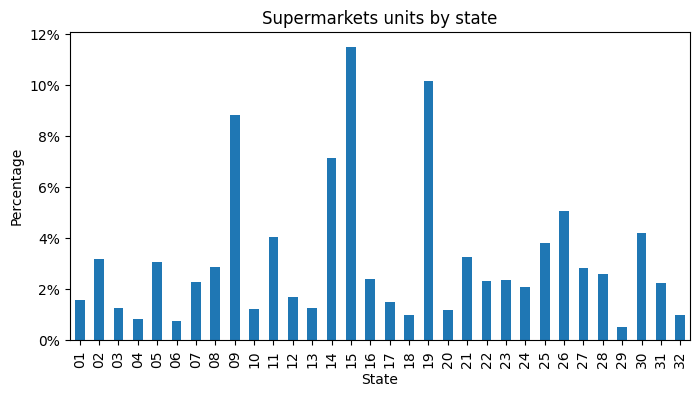

In [38]:
# eda
denue_eda(gdf_supermarkets, 'Supermarkets')

## Hospitals

In [39]:
# get hospitals
list_names = [
    'hospitales'
]

activity_ids = [
    '622111',  # private hospitals
    '622112',  # public hospitals
]

# fetch
gdf_hospitals = get_denue_units(list_names, activity_ids)

# see the data
print(gdf_hospitals.shape)
gdf_hospitals.sample(5)

100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

(4626, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,id_entidad_f,Fecha_Alta,geometry
1476,07049622112000025001000000U8,HOSPITAL BASICO COMUNITARIO LARRAINZAR,SECRETARIA DE SALUD FEDERAL,Hospitales generales del sector público,101 a 250 personas,622112,62211,070490001,07,2010-07-01,POINT (-92.71486 16.87900)
4477,20220931610000011000000000U7,UNIDAD MEDICA RURAL NUMERO 048 SAN JUAN TEPEUXILA,INSTITUTO MEXICANO DEL SEGURO SOCIAL,Hospitales generales del sector público,0 a 5 personas,622112,62211,202200001,20,2010-07-01,POINT (-96.84000 17.72340)
2440,21114622112000447000000000U8,HOSPITAL REGIONAL,HOSPITAL REGIONAL,Hospitales generales del sector público,251 y más personas,622112,62211,211140001,21,2010-07-01,POINT (-98.19929 19.02054)
2309,30039622111000073001000000U2,HOSPITAL MAY,,Hospitales generales del sector privado,11 a 30 personas,622111,62211,300390001,30,2010-07-01,POINT (-94.42805 18.14491)
2254,15040622112000026001000000U5,HOSPITAL ISSEMYM,GOBIERNO,Hospitales generales del sector público,101 a 250 personas,622112,62211,150400001,15,2010-07-01,POINT (-99.68267 18.84463)


In [40]:
# filter
gdf_hospitals = (
    gdf_hospitals
    .query("estrato_category >= '251 y más personas'")
    .reset_index(drop=True)
)

# see
print(gdf_hospitals.shape)

(670, 11)


### EDA


 ==========Razon social ==========
Razon_social
INSTITUTO MEXICANO DEL SEGURO SOCIAL                                          0.158209
INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE LOS TRABAJADORES DEL ESTADO    0.043284
                                                                              0.037313
OPERADORA DE HOSPITALES ANGELES SA DE CV                                      0.035821
IMSS                                                                          0.029851
GOBIERNO FEDERAL                                                              0.023881
GOBIERNO                                                                      0.020896
PETROLEOS MEXICANOS                                                           0.019403
SECRETARIA DE SALUD                                                           0.017910
SERVICIOS DE SALUD DE VERACRUZ                                                0.011940
Name: proportion, dtype: float64

 ==========Estrato ==========
estrato_category


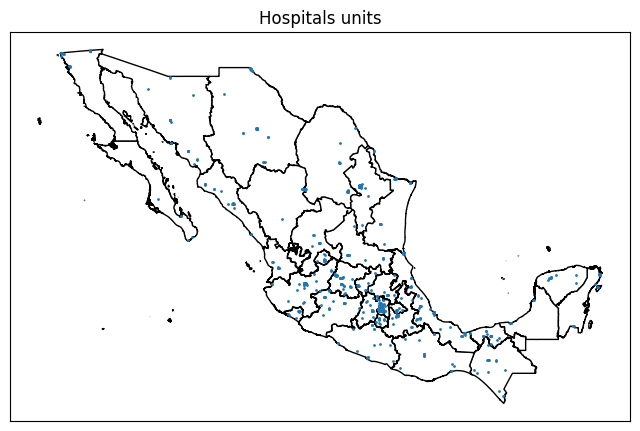

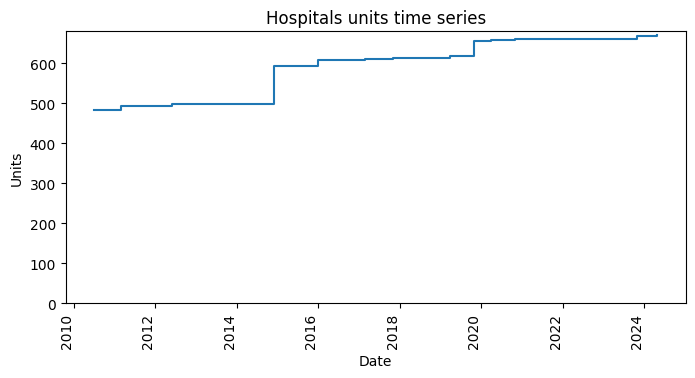

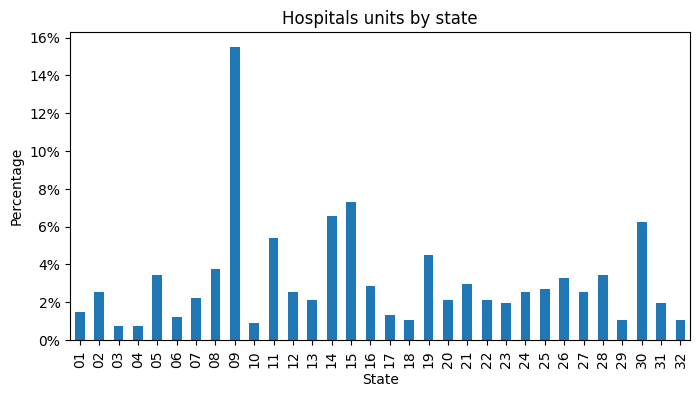

In [41]:
# eda
denue_eda(gdf_hospitals, 'Hospitals')

## Metro

This one is more artesanal

### Fetch

In [42]:
# get metro
list_names = [
    'metro'
]

activity_ids = [
    '485114',  # metro
]

# fetch
gdf_metro = get_denue_units(list_names, activity_ids)

# see the data
print(gdf_metro.shape)
gdf_metro.sample(5)

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

(413, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,id_entidad_f,Fecha_Alta,geometry
389,09003485114000051000000000U1,METROBUS,CONSECIONADO DEL SISTEMA DE CORREDORES DE TRAN...,Transporte colectivo urbano y suburbano de pas...,0 a 5 personas,485114,48511,090030001,09,2014-12-01,POINT (-99.18918 19.32003)
5,09015485114000641000014124S3,EDIFICIO DE LA ESTACION DEL METRO PINO SUAREZ,SISTEMA DE TRANSPORTE COLECTIVO METRO,Transporte colectivo urbano y suburbano de pas...,0 a 5 personas,485114,48511,090150001,09,2023-11-01,POINT (-99.13284 19.42577)
402,09015485114000117000014124M4,SISTEMA DE TRANSPORTE COLECTIVO METRO,SISTEMA DE TRANSPORTE COLECTIVO METRO,Transporte colectivo urbano y suburbano de pas...,251 y más personas,485114,48511,090150001,09,2014-12-01,POINT (-99.14341 19.42700)
229,09011485114000071000014124S2,ESTACION DEL METRO NOPALERA,SISTEMA DE TRANSPORTE COLECTIVO METRO,Transporte colectivo urbano y suburbano de pas...,0 a 5 personas,485114,48511,090110001,09,2014-12-01,POINT (-99.04593 19.29976)
409,09011485114000161000014124S1,TALLERES DE LA ESTACION DEL METRO TLAHUC,SISTEMA DE TRANSPORTE COLECTIVO METRO,Transporte colectivo urbano y suburbano de pas...,0 a 5 personas,485114,48511,090110001,09,2023-11-01,POINT (-99.01282 19.28323)


### Filtering

In [44]:
# see cve_ents
gdf_metro['AreaGeo'].str[:2].value_counts()

AreaGeo
09    351
19     35
15     23
11      3
14      1
Name: count, dtype: int64

In [45]:
# drop rows with cve_ents eq to 11 or 14
mask = gdf_metro['AreaGeo'].str[:2].isin(['11', '14'])
gdf_metro = gdf_metro[~mask].reset_index(drop=True)
gdf_metro.shape

(409, 11)

In [48]:
# explore
gdf_metro.loc[:, ['Nombre', 'geometry']].explore(tiles='CartoDB positron')

^^^
there are more than 1 metro stations in the same location, we need to cluster them

### Clean

In [49]:
# get longitude & latitude
gdf_metro = gdf_metro.to_crs('EPSG:6372')
gdf_metro['longitude'] = gdf_metro.centroid.x
gdf_metro['latitude'] = gdf_metro.centroid.y
# return to 4326
gdf_metro = gdf_metro.to_crs('EPSG:4326')

In [72]:
# use dbscan to cluster metro stations
eps = 250 # meters
min_samples = 2

# get clusters
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
gdf_metro['cluster'] = dbscan.fit_predict(gdf_metro[['latitude', 'longitude']])

In [74]:
# see clusters
gdf_metro['cluster'].value_counts()

cluster
-1      86
 3       9
 101     8
 1       6
 113     5
        ..
 55      2
 53      2
 51      2
 50      2
 130     2
Name: count, Length: 132, dtype: int64

In [75]:
# get only first observation for each cluster
gdf_metro_unique_clusters = gdf_metro.query("cluster == -1").copy()
gdf_metro_multiple_clusters = gdf_metro.query("cluster != -1").drop_duplicates('cluster', keep='first').copy()

# for multiple clusters, get the average of latitude and longitude
gdf_metro_multiple_clusters['longitude'] = gdf_metro_multiple_clusters.groupby('cluster')['longitude'].transform('mean')
gdf_metro_multiple_clusters['latitude'] = gdf_metro_multiple_clusters.groupby('cluster')['latitude'].transform('mean')

# join
gdf_metro2 = pd.concat([gdf_metro_unique_clusters, gdf_metro_multiple_clusters], axis=0)
gdf_metro2.shape

# set new geometry
gdf_metro2['geometry'] = gdf_metro2.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
gdf_metro2 = gpd.GeoDataFrame(gdf_metro2, geometry='geometry', crs='EPSG:6372')

# change crs
gdf_metro2 = gdf_metro2.to_crs('EPSG:4326')


In [76]:
# explore
gdf_metro2.loc[:, ['Nombre', 'geometry']].explore(tiles='CartoDB positron')

### EDA


 ==========Razon social ==========
Razon_social
SISTEMA DE TRANSPORTE COLECTIVO METRO                                                        0.834101
SISTEMA DE TRANSPORTE COLECTIVO METRORREY                                                    0.147465
ESTACION DEL MEXIBUS LINEA 2                                                                 0.004608
FERROCARRILES SUBURBANOS SAPI DE CV                                                          0.004608
SISTEMA DE TRANSPORTE DE PASAJEROS GOBIERNO DEL DISTRITO FEDERAL                             0.004608
CONCESIONADO AL SISTEMA DE CORREDORES DE TRANSPORTE PÚBLICO DEL DISTRITO FEDERAL METROBUS    0.004608
Name: proportion, dtype: float64

 ==========Estrato ==========
estrato_category
0 a 5 personas        0.764977
6 a 10 personas       0.124424
11 a 30 personas      0.069124
31 a 50 personas      0.013825
51 a 100 personas     0.018433
101 a 250 personas    0.000000
251 y más personas    0.009217
Name: proportion, dtype: float64


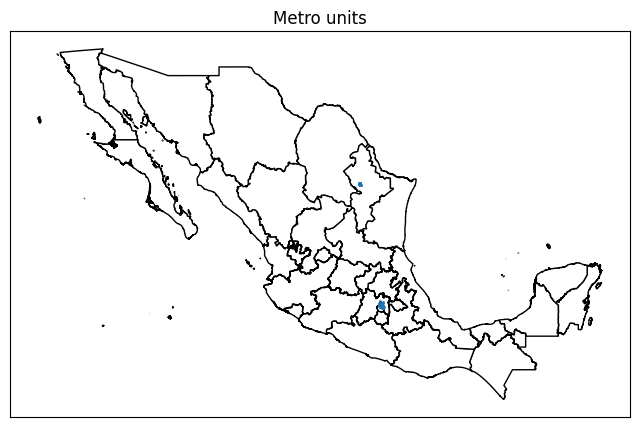

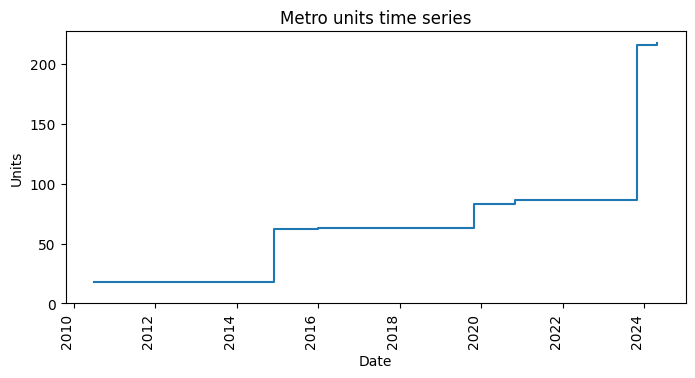

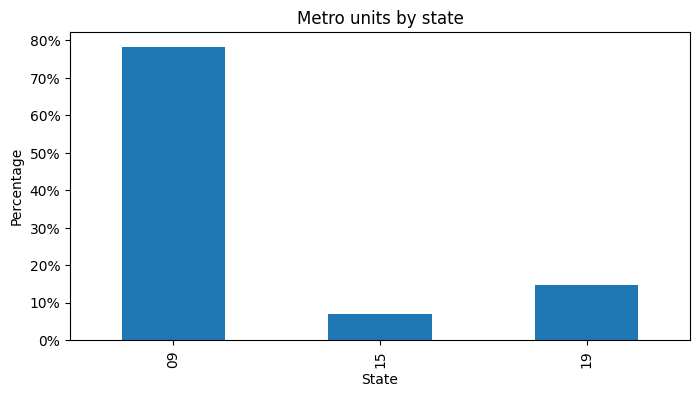

In [77]:
# eda
denue_eda(gdf_metro2, 'Metro')

## Schools

In [78]:
# schools
list_names = [
    'universidad', 'escuela', 'colegio', 'instituto', 'campus'
]

activity_ids = [
    '611311',  # private universities
    '611312',  # public schools
]

# fetch
gdf_schools = get_denue_units(list_names, activity_ids)

# see the data
print(gdf_schools.shape)
gdf_schools.sample(5)

100%|██████████| 5/5 [01:17<00:00, 15.43s/it]


(7351, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,id_entidad_f,Fecha_Alta,geometry
4286,07101611311000591001000000U9,CENTRO DE ESPECIALIDADES EN ARTES CULINARIAS,CENTRO EDUCATIVO DE ARTES GASTRONOMIAS,Escuelas de educación superior del sector privado,6 a 10 personas,611311,61131,071010001,07,2014-12-01,POINT (-93.12687 16.75289)
2584,09015611311002086000006957S8,UNIVERSIDAD DEL VALLE DE MEXICO,UNIVERSIDAD DEL VALLE DE MEXICO SC,Escuelas de educación superior del sector privado,101 a 250 personas,611311,61131,090150001,09,2023-11-01,POINT (-99.15845 19.42296)
6834,19026611312000037000000000U6,INSTITUTO TECNOLOGICO DE NUEVO LEON,INSTITUTO TECNOLOGICO DE NUEVO LEÓN,Escuelas de educación superior del sector público,251 y más personas,611312,61131,190260001,19,2010-07-01,POINT (-100.24554 25.66386)
4824,14039611311000756001006214S1,CENTRO UNIVERSITARIO UTEG,CENTRO UNIVERSITARIO UTEG SC,Escuelas de educación superior del sector privado,251 y más personas,611311,61131,140390001,14,2014-12-01,POINT (-103.32564 20.65283)
2493,28022611311000093001037861S9,UNIVERSIDAD DEL NORESTE DE MEXICO ESTACIONAMIENTO,UNIVERSIDAD DEL NORESTE DE MEXICO AC,Escuelas de educación superior del sector privado,31 a 50 personas,611311,61131,280220001,28,2010-07-01,POINT (-97.50357 25.86328)


In [79]:
# filter
gdf_schools = (
    gdf_schools
    .query("estrato_category >= '251 y más personas'")  # big universities
    .query("Razon_social != '' & Nombre != ''")  # should be named
    .reset_index(drop=True)
)

# see
print(gdf_schools.shape)
gdf_schools.sample(5)

(499, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,id_entidad_f,Fecha_Alta,geometry
234,05030611311000136001000000U6,UNIVERSIDAD LA SALLE SALTILLO,UNIVERSIDAD LA SALLE SALTILLO AC,Escuelas de educación superior del sector privado,251 y más personas,611311,61131,050300001,05,2010-07-01,POINT (-100.91375 25.45988)
414,08017611312000036000000000U4,INSTITUTO TECNOLOGICO DE CD CUAUHTEMOC,TECNOLOGICO NACIONAL DE MEXICO INSTITUTOTECNOL...,Escuelas de educación superior del sector público,251 y más personas,611312,61131,080170001,08,2010-07-01,POINT (-106.89905 28.41384)
419,08017611312000087000000000U3,INSTITUTO TECNOLOGICO DE CIUDAD CUAUHTÉMOC,TECNOLOGICO NACIONAL DE MEXICO,Escuelas de educación superior del sector público,251 y más personas,611312,61131,080170001,08,2020-11-01,POINT (-106.89788 28.41144)
196,14098611311000067002006957S9,UNIVERSIDAD DEL VALLE DE MEXICO,UNIVERSIDAD DEL VALLE DE MEXICO SC,Escuelas de educación superior del sector privado,251 y más personas,611311,61131,141200001,14,2010-07-01,POINT (-103.45536 20.67573)
223,26030611311000245002011495M0,UNIVERSIDAD KINO,UNIVERSIDAD KINO AC,Escuelas de educación superior del sector privado,251 y más personas,611311,61131,260300001,26,2010-07-01,POINT (-110.93719 29.07720)


### EDA

In [ ]:
# count CLASE_ACTIVIDAD_ID
gdf_schools['CLASE_ACTIVIDAD_ID'].value_counts()


 ==========Razon social ==========
Razon_social
TECNOLOGICO NACIONAL DE MEXICO                                 0.054108
INSTITUTO POLITÉCNICO NACIONAL                                 0.048096
UNIVERSIDADES TECNOLOGICAS Y POLITÉCNICAS                      0.044088
UNIVERSIDAD DEL DESARROLLO PROFESIONAL SC                      0.038076
UNIVERSIDAD DEL VALLE DE MEXICO SC                             0.036072
UNIVERSIDAD NACIONAL AUTONOMA DE MEXICO                        0.030060
INSTITUTO TECNOLOGICO Y DE ESTUDIOS SUPERIORES DE MONTERREY    0.022044
UNIVERSIDAD TECNOLOGICA DE MEXICO SC                           0.020040
SECRETARIA DE EDUCACION PÚBLICA                                0.018036
UNIVERSIDAD DE GUADALAJARA                                     0.018036
Name: proportion, dtype: float64

 ==========Estrato ==========
estrato_category
0 a 5 personas        0.0
6 a 10 personas       0.0
11 a 30 personas      0.0
31 a 50 personas      0.0
51 a 100 personas     0.0
101 a 250 personas  

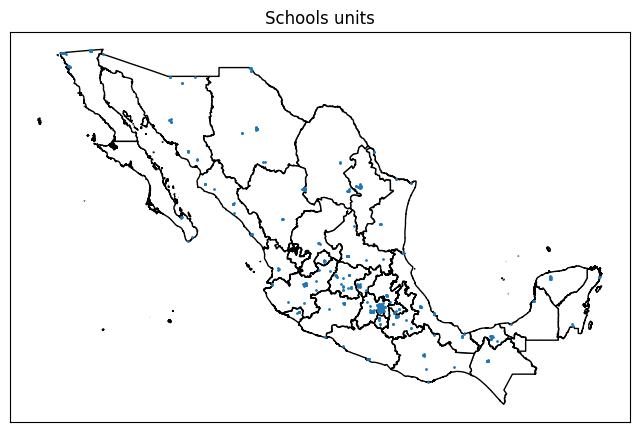

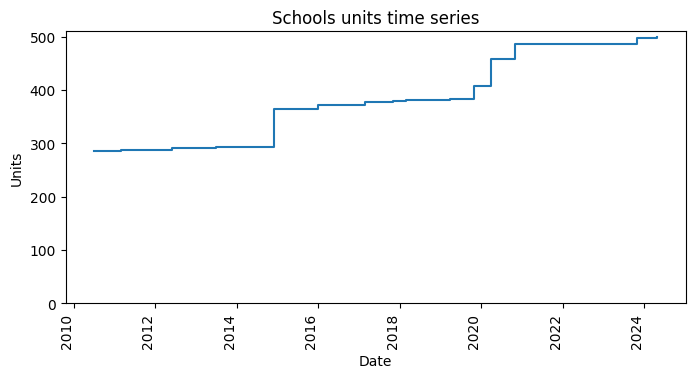

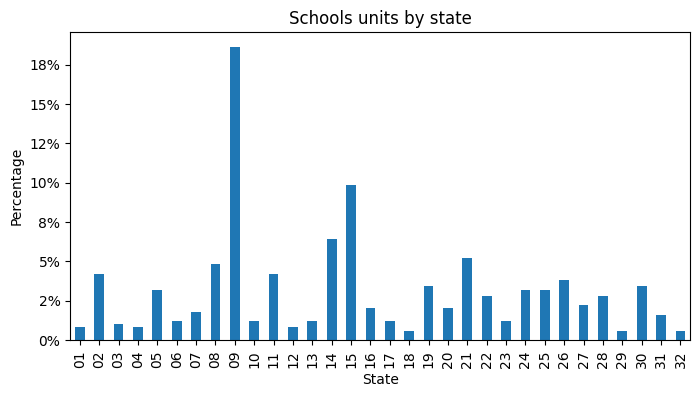

In [80]:
# general eda
denue_eda(gdf_schools, 'Schools')

## Restaurants

In [81]:
# get restaurants
list_names = [
    'restaurante', 'cafeteria', 'sushi', 'comida'
]

activity_ids = [
    '722511',  # restaurants
    '722512',  # seafood restaurants
]

# fetch
gdf_restaurants = get_denue_units(list_names, activity_ids)

# see the data
print(gdf_restaurants.shape)

100%|██████████| 4/4 [02:39<00:00, 39.86s/it]


(65664, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,id_entidad_f,Fecha_Alta,geometry
40864,16083722511000022000000000U5,RESTAURANT EMPERADOR,RESTAURAT BAR,Restaurantes con servicio de preparación de al...,6 a 10 personas,722511,72251,160830001,16,2019-11-01,POINT (-102.36160 19.33741)
46910,09012722219008642000000000U0,RESTAURANTE CARNES ASADAS STEAK BEANS,,Restaurantes con servicio de preparación de al...,11 a 30 personas,722511,72251,090120001,09,2010-07-01,POINT (-99.21743 19.29038)
5310,26026722511000031000000000U3,CASETA PLAZA,,Restaurantes con servicio de preparación de al...,0 a 5 personas,722511,72251,260260001,26,2014-12-01,POINT (-109.62609 26.91147)
38463,08032722511000471000000000U1,RESTAURANT BAR BUFALUCAS,BUFALUCAS,Restaurantes con servicio de preparación de al...,0 a 5 personas,722511,72251,080320001,08,2020-11-01,POINT (-105.65119 26.92701)
56509,23004722110000583000000000U4,RESTAURANTE PANTOJA,,Restaurantes con servicio de preparación de al...,6 a 10 personas,722511,72251,230040001,23,2010-07-01,POINT (-88.29403 18.50358)


In [85]:
# filter
# mask
mask = (
    gdf_restaurants['Nombre'].ne('')  # known name
    & gdf_restaurants['estrato_category'].ge('6 a 10 personas')
    & gdf_restaurants['estrato_category'].le('51 a 100 personas') 
    & gdf_restaurants['Razon_social'].ne('')  # known razon social
)
gdf_restaurants = gdf_restaurants[mask].reset_index(drop=True)

# see
print(gdf_restaurants.shape)
gdf_restaurants.sample(5)

(8192, 11)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,id_entidad_f,Fecha_Alta,geometry
5708,01001722511004042000058267S8,RESTAURANTE EL SATO,OPERADORA DE GASTRONOMIA JAPONESA SA DE CV,Restaurantes con servicio de preparación de al...,6 a 10 personas,722511,72251,010010001,01,2023-11-01,POINT (-102.29038 21.92357)
2010,09016722511001304001000000U5,EL DIEZ,EL ARGENTINO LOMAS SA DE CV,Restaurantes con servicio de preparación de al...,11 a 30 personas,722511,72251,090160001,09,2010-07-01,POINT (-99.21157 19.42723)
1052,15033722110001834002003628S9,CHILIS 1012 LAS AMERICAS,GASTRO SUR SA DE CV,Restaurantes con servicio de preparación de al...,51 a 100 personas,722511,72251,150330001,15,2010-07-01,POINT (-99.02459 19.58194)
3548,02004722511004893000000000U7,LOS COMPAS,LOS COMPAS,Restaurantes con servicio de preparación de al...,11 a 30 personas,722511,72251,020040001,02,2019-11-01,POINT (-117.00982 32.51499)
962,15121722511002413000000000U3,CENTRO HISTORICO,ALIMENTOS CENTRO HISTORICO,Restaurantes con servicio de preparación de al...,11 a 30 personas,722511,72251,151210001,15,2019-11-01,POINT (-99.21463 19.65187)


### EDA


 ==========Razon social ==========
Razon_social
OPERADORA VIPS S DE RL DE CV                       0.027832
RESTAURANTES TOKS SA DE CV                         0.025024
GASTRO SUR SA DE CV                                0.007446
LAS NUEVAS DELICIAS GASTRONOMICAS S DE RL DE CV    0.005737
RESTAURANTE LAS ALITAS SA DE CV                    0.005249
FLY BY WINGS SA DE CV                              0.005127
NOVALIMENTOS DE MEXICO S DE RL DE CV               0.004150
GMA OPERADORA DE FRANQUICIAS SAPI DE CV            0.003540
AEROCOMIDAS SA DE CV                               0.003296
SUSHI ROLL SA DE CV                                0.003052
Name: proportion, dtype: float64

 ==========Estrato ==========
estrato_category
0 a 5 personas        0.000000
6 a 10 personas       0.231567
11 a 30 personas      0.448120
31 a 50 personas      0.188477
51 a 100 personas     0.131836
101 a 250 personas    0.000000
251 y más personas    0.000000
Name: proportion, dtype: float64


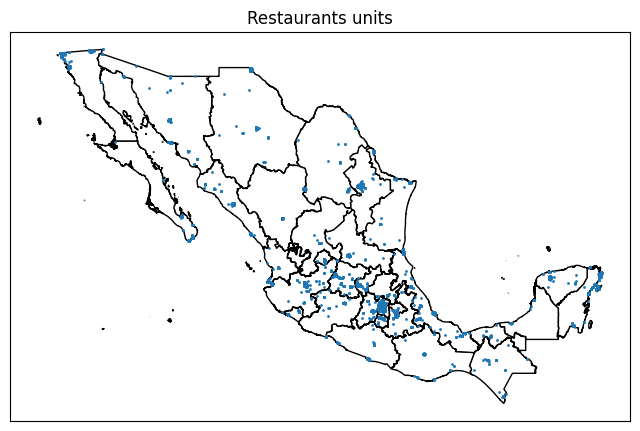

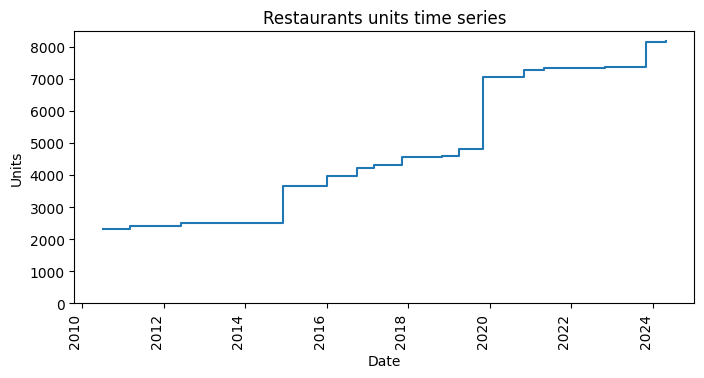

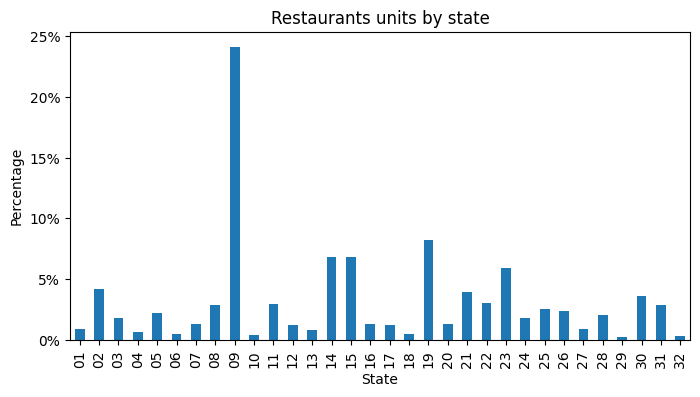

In [86]:
# general eda
denue_eda(gdf_restaurants, 'Restaurants')

## Concat All

In [90]:
# append all into one
gdf_denue = pd.concat([
    gdf_supermarkets.assign(category='supermarkets'),
    gdf_hospitals.assign(category='hospitals'),
    gdf_metro2.assign(category='metro'),
    gdf_schools.assign(category='schools'),
    gdf_restaurants.assign(category='restaurants')
], axis=0)

# delete longitude, latitude and cluster
gdf_denue = gdf_denue.drop(columns=['longitude', 'latitude', 'cluster'])

# see
print(gdf_denue.shape)
gdf_denue.sample(5)

(14225, 12)


,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,AreaGeo,id_entidad_f,Fecha_Alta,geometry,category
1576,26030462111001116000010698S6,BODEGA DE ABARROTES HERMOSILLO 4242 6239,CASA LEY SAPI DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,46211,260300001,26,2010-07-01,POINT (-111.07966 29.07459),supermarkets
3943,15110462111000035001008292S2,SORIANA SUPER VALLE DE BRAVO SUCURSAL 0628,TIENDAS SORIANA SA DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,46211,151100001,15,2019-04-01,POINT (-100.13308 19.20302),supermarkets
2360,15037722511000944000000000U7,FRIENDS DELI,STARWICH DELI SA DE CV,Restaurantes con servicio de preparación de al...,31 a 50 personas,722511,72251,150370071,15,2019-11-01,POINT (-99.27533 19.40173),restaurants
3992,02004462111002005000010698S3,SUPER LEY CUCAPAH 1278,CASA LEY SAPI DE CV,Comercio al por menor en supermercados,51 a 100 personas,462111,46211,020040001,02,2016-01-01,POINT (-116.85515 32.51508),supermarkets
5451,20067722511004004000000000U6,RESTAURANTE CASA PALMERAS,GRUPO HORIZONTE GOURMET SA DE CV,Restaurantes con servicio de preparación de al...,31 a 50 personas,722511,72251,200670001,20,2019-11-01,POINT (-96.71718 17.07631),restaurants


In [91]:
# see crs
gdf_denue.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: xlabel='id_entidad_f'>

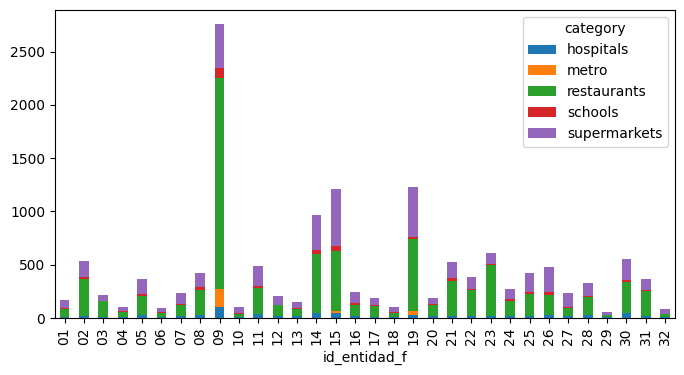

In [96]:
# count category by state
gdf_denue.groupby(['id_entidad_f', 'category']).size().unstack().plot(kind='bar', stacked=True, figsize=(8, 4))

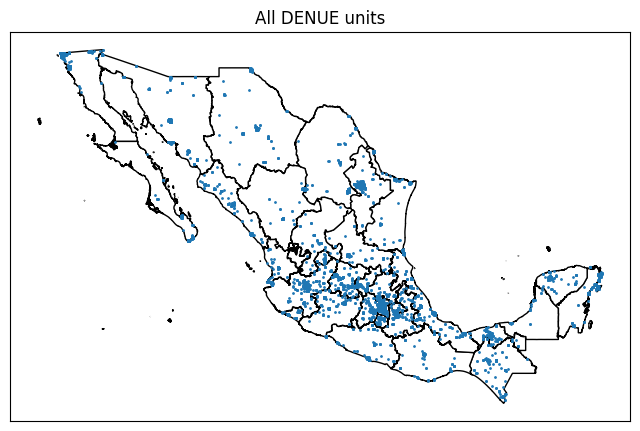

In [92]:
# plot
plot_denues(gdf_denue, 'All DENUE')

In [89]:
# count unique clee
gdf_denue['CLEE'].nunique()

14225

## Save

In [93]:
# save data into misc
dir_save = '../../data/misc'
os.makedirs(dir_save, exist_ok=True)

# save
gdf_denue.to_parquet(f'{dir_save}/denue_data.parquet')

---
# Count Of Units

## Count

In [101]:
# define function to get poiunts at r distance
def count_denues(gdf_props, gdf_denues, r=1):
    # fit a kdtree
    kdtree = KDTree(
        data=gdf_denues[['longitude', 'latitude']],
    )

    # count neighbors at r-km
    return kdtree.query_ball_point(
        gdf_props[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1,
        return_length=True
    )

In [102]:
# set crs to 6372
gdf_properties = gdf_properties.to_crs('EPSG:6372')
gdf_denue = gdf_denue.to_crs('EPSG:6372')

# get longitude & latitude
gdf_properties['longitude'] = gdf_properties.centroid.x
gdf_properties['latitude'] = gdf_properties.centroid.y

gdf_denue['longitude'] = gdf_denue.centroid.x
gdf_denue['latitude'] = gdf_denue.centroid.y

In [114]:
# count denues
dict_activities_search = {
    'supermarkets': 1,  # 1 km
    'hospitals': 5,
    'metro': 1,
    'schools': 1,
    'restaurants': 1
}

# count
for category, radius in tqdm(dict_activities_search.items()):
    gdf_properties[f'count_{category}'] = count_denues(
        gdf_properties,
        gdf_denue.query("category == @category"),
        r=radius
        )

100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


## EDA

In [117]:
# describe
vars2describe = gdf_properties.columns[gdf_properties.columns.str.startswith('count_')]
gdf_properties[vars2describe].describe()

,count_supermarkets,count_hospitals,count_metro,count_schools,count_restaurants
count,852913.000000,852913.000000,852913.000000,852913.000000,852913.000000
mean,0.975924,2.384337,0.088542,0.071591,1.710024
std,1.279530,5.289261,0.493455,0.372734,8.610543
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,0.000000,0.000000
max,11.000000,41.000000,9.000000,13.000000,231.000000


In [116]:
# see how many have at least one
gdf_properties[vars2describe].gt(0).mean().to_frame().T

,count_supermarkets,count_hospitals,count_metro,count_schools,count_restaurants
0,0.513222,0.537633,0.040273,0.051698,0.202811


---
# Sandbox